# Kaggle Credit card fraud dataset analysis

Get the dataset from here: 
https://www.kaggle.com/dalpozz/creditcardfraud

## Goal

I'm gonna follow the stages defined in [Practical Data Science With R](https://www.amazon.in/gp/product/935119437X/ref=as_li_tl?ie=UTF8&camp=3638&creative=24630&creativeASIN=935119437X&linkCode=as2&tag=praj-21&linkId=ba3a4b019f14ccfac8c3a9d4e13d8ef9)

1. Define the goal
2. Collect and manage data
3. Build the model
4. Evaluate and Critique model
5. Present results and document
6. Deploy model

### Our goal

Use the features defined in the credit card dataset as well as their labels to build models that are accurately able to classify a transcation as fraudulent

### Data collection

Download from the Kaggle website. Comes in a zipped csv format

### Build a Model
#### EDA
We need to expore the dataset to understand the variable characteristics. This will enable us to pick the right family of models to build

In [23]:
install.packages("GGally")

Installing package into ‘/home/praj/R/x86_64-pc-linux-gnu-library/3.3’
(as ‘lib’ is unspecified)


In [143]:
library(dplyr)
library(reshape2)
library(ggplot2)
library(parallel)
library(caret)
library(GGally)
library(ggthemes)
library(vtreat)
library(data.table)
library(dtplyr)
library(magrittr)
options(mc.cores=detectCores())

In [4]:
unzip("creditcardfraud.zip")

In [135]:
ccdat = fread('creditcard.csv')

Read 284807 rows and 31 (of 31) columns from 0.140 GB file in 00:00:03


## Preprocessing

In [137]:
ccdat %>% dim

[1] 284807     31

Looks like we have 284k rows and 31 columns.

In [138]:
colnames(ccdat)

[1] "Time"   "V1"     "V2"     "V3"     "V4"     "V5"     "V6"     "V7"    
 [9] "V8"     "V9"     "V10"    "V11"    "V12"    "V13"    "V14"    "V15"   
[17] "V16"    "V17"    "V18"    "V19"    "V20"    "V21"    "V22"    "V23"   
[25] "V24"    "V25"    "V26"    "V27"    "V28"    "Amount" "Class"

Okay, let's check the column types. 

In [139]:
lapply(ccdat, class) %>% unlist %>% table

.
character   numeric 
        1        30 

Looks like the 'Class' column is the only integer and everything else is numeric. 

Let's convert Class to a factor (discrete levels)

In [144]:
ccdat$Class %<>% as.factor

We have 492 of calss '1'. Safe to assume, these are the fraudulent transactions. Let's do some EDA
### Exploratory Data Analysis

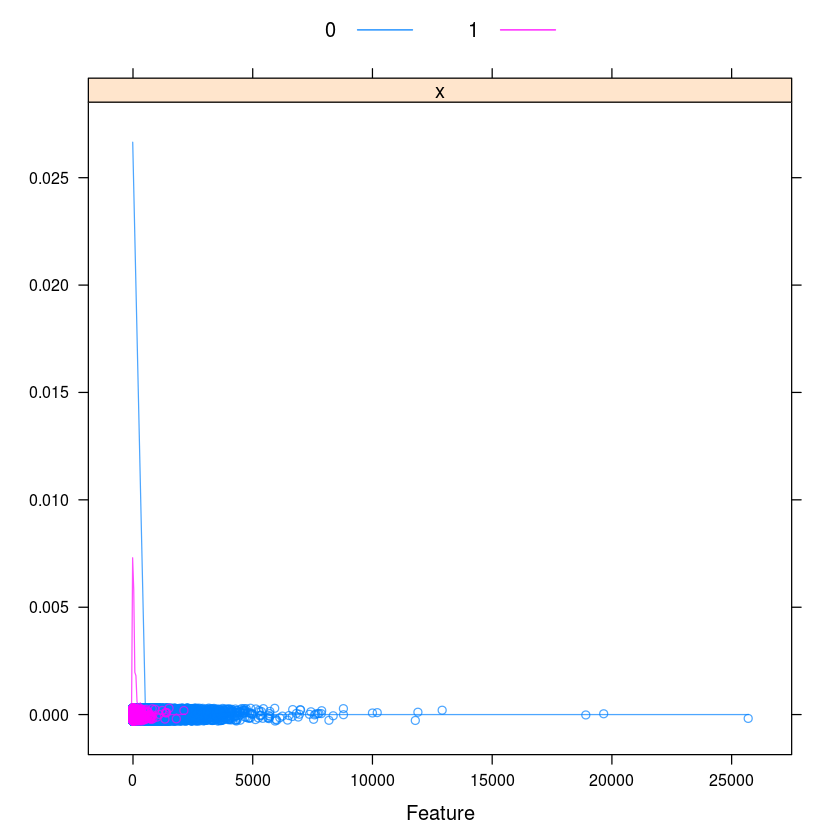

In [147]:
featurePlot(x =ccdat$Amount, y = ccdat$Class, plot='density', auto.key=list(columns=2), alpha=0.7)

Looks a lot like all the fraudulent transcations happened when the amount was below 5000

In [148]:
ccdat %>% select(Amount, Class) %>% filter(Class == 1 & Amount > 5000) %>% head %>% print
ccdat %>% select(Amount, Class) %>% filter(Class == 1) %>% select(Amount) %>% max

Empty data.table (0 rows) of 2 cols: Amount,Class


NULL

[1] 2125.87

#### Looks like the maximum fraudulent amount was 2125.87$

In [156]:
(ccdat %>% select(Amount) %>% filter(Amount > 2126) %>% dim)[1]

[1] 602

#### Let's compare variable densities for fraudulent(FR) v/s non fraudulent(NFR) transcations
### 0 - NFR 
### 1 - FR

In the density plots, variables whose densities stay

In [215]:
## Plot variable densities with the fill colour standing 
## for whether that transcation was fraudulent
plotDens <- function(dff, idxs) {
    ggplot(dff[,idxs] %>% melt(id.vars=c('Class'))) + 
    geom_density(aes(x=value, fill=Class), alpha = 0.3) + 
    facet_grid(variable~., scales='free_y')+ xlim(-25,10)
}

Warning message:
“Removed 983 rows containing non-finite values (stat_density).”

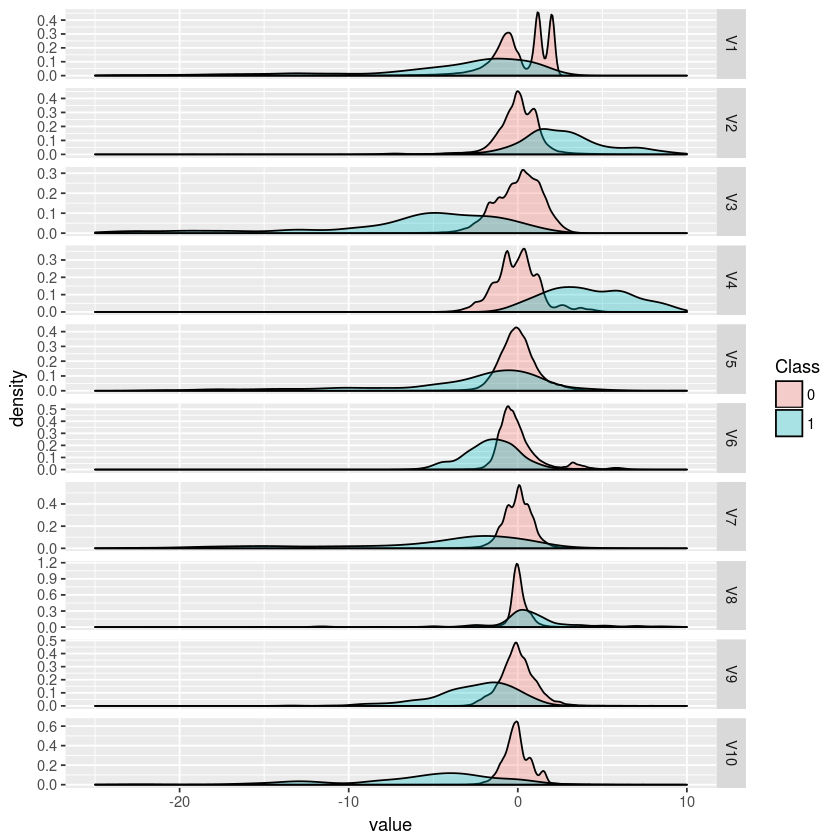

In [216]:
plotDens(ccdat %>% as.data.frame, c(2:11, 31)) 

Warning message:
“Removed 79 rows containing non-finite values (stat_density).”

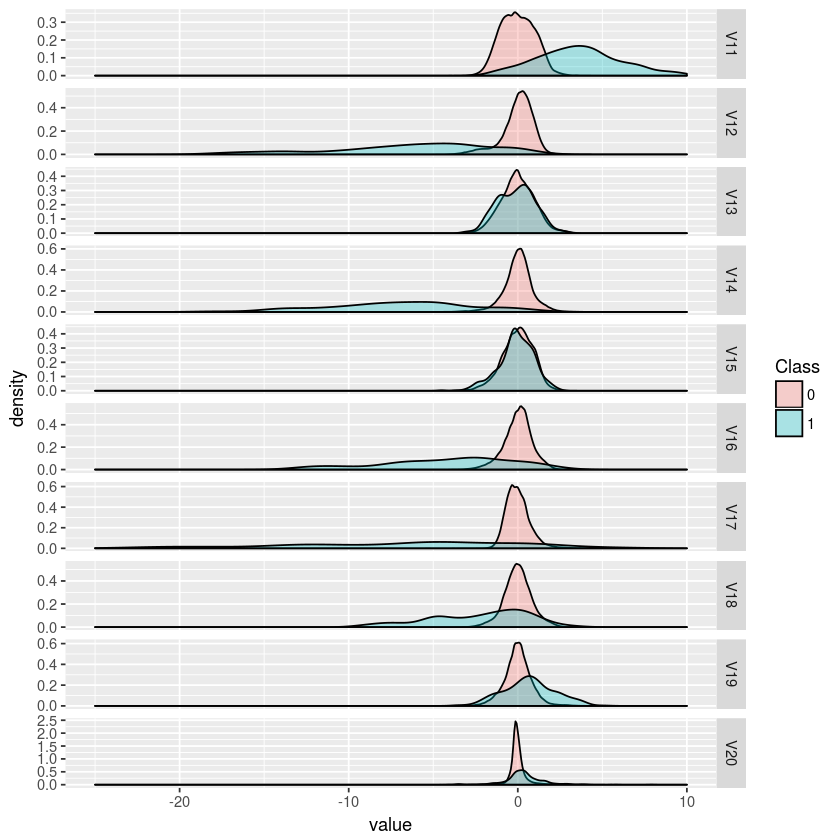

In [217]:
plotDens(ccdat %>% as.data.frame, c(12:21, 31))

Warning message:
“Removed 184798 rows containing non-finite values (stat_density).”

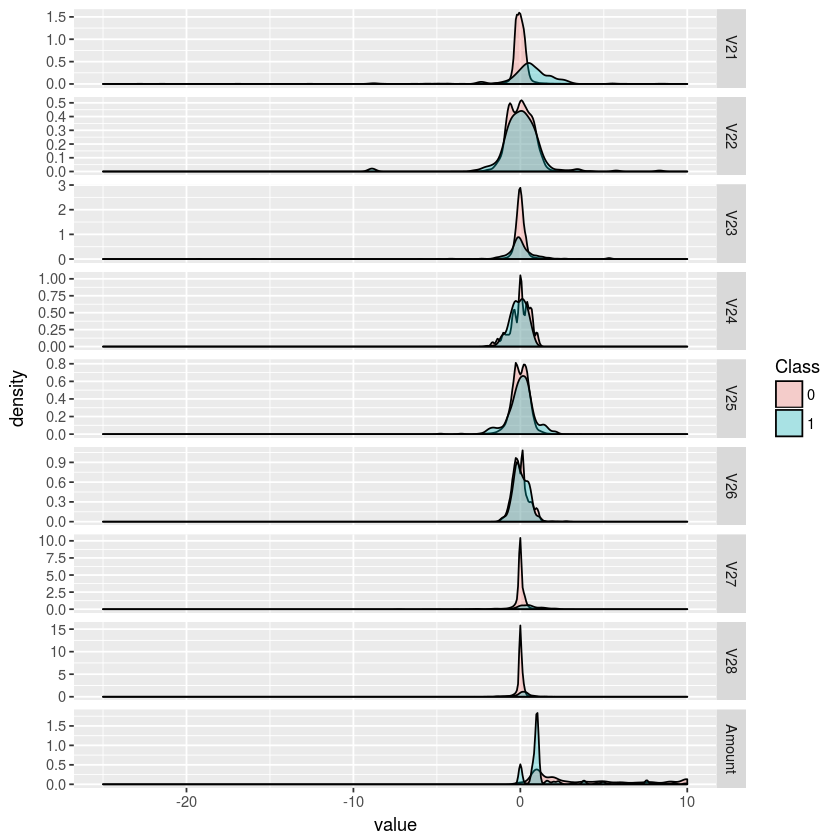

In [218]:
plotDens(ccdat%>% as.data.frame, c(22:31))

#### It might make sense to drop all the variables whose densities don't differ much based on the outcome we are looking at

### Pre-process all the features
- We'll use [vtreat](https://cran.r-project.org/web/packages/vtreat/vignettes/vtreat.html) to treat the dataframe.
- We'll also use caret to find nearZeroVariance features

In [173]:
nav = nearZeroVar(ccdat, saveMetrics = T)

In [174]:
print(nav)

        freqRatio percentUnique zeroVar   nzv
Time     1.384615  4.374612e+01   FALSE FALSE
V1       1.000000  9.409284e+01   FALSE FALSE
V2       1.000000  9.592250e+01   FALSE FALSE
V3       1.000000  9.563669e+01   FALSE FALSE
V4       1.000000  9.589547e+01   FALSE FALSE
V5       1.000000  9.605522e+01   FALSE FALSE
V6       1.000000  9.596007e+01   FALSE FALSE
V7       1.000000  9.612369e+01   FALSE FALSE
V8       1.000000  9.618584e+01   FALSE FALSE
V9       1.000000  9.603837e+01   FALSE FALSE
V10      1.000000  9.608612e+01   FALSE FALSE
V11      1.000000  9.568901e+01   FALSE FALSE
V12      1.000000  9.611035e+01   FALSE FALSE
V13      1.000000  9.597376e+01   FALSE FALSE
V14      1.000000  9.619321e+01   FALSE FALSE
V15      1.000000  9.596428e+01   FALSE FALSE
V16      1.000000  9.611842e+01   FALSE FALSE
V17      1.000000  9.614722e+01   FALSE FALSE
V18      1.000000  9.615564e+01   FALSE FALSE
V19      1.000000  9.614827e+01   FALSE FALSE
V20      1.000000  9.600853e+01   

nearZeroVar wasn't any helpful at all as it picked out our outcome as the only near zero variance column.

#### First, let's split ccfraud into test and train frames with a 30 - 70 split

In [161]:
trainIdx = createDataPartition(ccdat$Class, p = 0.7, times = 1, list = F) 

In [162]:
cctrain = ccdat[trainIdx, ]
cctest = ccdat[-trainIdx, ]

In [164]:
table(cctrain$Class)


     0      1 
199021    345 

#### Let's try to build a treatment plan for this data frame using vtreat

In [165]:
treatment = designTreatmentsC(cctrain, colnames(cctrain), 'Class', 1)

[1] "desigining treatments Sun Mar 19 23:45:49 2017"
[1] "designing treatments Sun Mar 19 23:45:49 2017"
[1] " have level statistics Sun Mar 19 23:45:49 2017"
[1] "design var Time Sun Mar 19 23:45:49 2017"
[1] "design var V1 Sun Mar 19 23:45:49 2017"
[1] "design var V2 Sun Mar 19 23:45:49 2017"
[1] "design var V3 Sun Mar 19 23:45:50 2017"
[1] "design var V4 Sun Mar 19 23:45:50 2017"
[1] "design var V5 Sun Mar 19 23:45:50 2017"
[1] "design var V6 Sun Mar 19 23:45:50 2017"
[1] "design var V7 Sun Mar 19 23:45:50 2017"
[1] "design var V8 Sun Mar 19 23:45:51 2017"
[1] "design var V9 Sun Mar 19 23:45:51 2017"
[1] "design var V10 Sun Mar 19 23:45:51 2017"
[1] "design var V11 Sun Mar 19 23:45:51 2017"
[1] "design var V12 Sun Mar 19 23:45:51 2017"
[1] "design var V13 Sun Mar 19 23:45:51 2017"
[1] "design var V14 Sun Mar 19 23:45:52 2017"
[1] "design var V15 Sun Mar 19 23:45:52 2017"
[1] "design var V16 Sun Mar 19 23:45:52 2017"
[1] "design var V17 Sun Mar 19 23:45:52 2017"
[1] "design var V18 S

In [166]:
print(treatment)

$treatments
$treatments[[1]]
[1] "vtreat 'Scalable pass through'('Time'(double,numeric)->numeric->'Time_clean')"

$treatments[[2]]
[1] "vtreat 'Scalable pass through'('V1'(double,numeric)->numeric->'V1_clean')"

$treatments[[3]]
[1] "vtreat 'Scalable pass through'('V2'(double,numeric)->numeric->'V2_clean')"

$treatments[[4]]
[1] "vtreat 'Scalable pass through'('V3'(double,numeric)->numeric->'V3_clean')"

$treatments[[5]]
[1] "vtreat 'Scalable pass through'('V4'(double,numeric)->numeric->'V4_clean')"

$treatments[[6]]
[1] "vtreat 'Scalable pass through'('V5'(double,numeric)->numeric->'V5_clean')"

$treatments[[7]]
[1] "vtreat 'Scalable pass through'('V6'(double,numeric)->numeric->'V6_clean')"

$treatments[[8]]
[1] "vtreat 'Scalable pass through'('V7'(double,numeric)->numeric->'V7_clean')"

$treatments[[9]]
[1] "vtreat 'Scalable pass through'('V8'(double,numeric)->numeric->'V8_clean')"

$treatments[[10]]
[1] "vtreat 'Scalable pass through'('V9'(double,numeric)->numeric->'V9_clean')"

$tr

In [172]:
cctrain.treated = prepare(treatment, cctrain, pruneSig=c(), scale=T)
str(cctrain.treated)

'data.frame':	199366 obs. of  31 variables:
 $ Time_clean  : num  0.00115 0.00115 0.00115 0.00115 0.00115 ...
 $ V1_clean    : num  0.00295 0.00294 0.00251 0.00194 0.00073 ...
 $ V2_clean    : num  -0.000175 -0.003112 0.002027 0.000656 0.002587 ...
 $ V3_clean    : num  -0.013332 -0.009314 -0.008132 0.000618 -0.005477 ...
 $ V4_clean    : num  0.005366 0.001478 0.001569 -0.001058 -0.000866 ...
 $ V5_clean    : num  0.000926 0.001379 0.001115 -0.007332 -0.001374 ...
 $ V6_clean    : num  -0.000634 -0.002478 -0.00013 -0.005125 0.000343 ...
 $ V7_clean    : num  -0.00152 -0.005 -0.00375 -0.00235 -0.00412 ...
 $ V8_clean    : num  3.05e-05 7.55e-05 -8.11e-05 2.58e-04 2.17e-05 ...
 $ V9_clean    : num  -0.00133 0.00554 -0.00299 0.00143 0.00269 ...
 $ V10_clean   : num  -0.000763 -0.001732 -0.006257 0.003396 0.003034 ...
 $ V11_clean   : num  -0.00353 0.00399 -0.00527 -0.00451 0.00651 ...
 $ V12_clean   : num  0.006765 -0.000702 -0.005856 0.001226 -0.009112 ...
 $ V13_clean   : num  2.94e-04